Episode: 0, Reward: -5
Success Rate: 0.00%
Episode: 1, Reward: -5
Success Rate: 0.00%
Episode: 2, Reward: -5
Success Rate: 0.00%
Episode: 3, Reward: -5
Success Rate: 0.00%
Episode: 4, Reward: -5
Success Rate: 0.00%
Episode: 5, Reward: -5
Success Rate: 0.00%
Episode: 6, Reward: -5
Success Rate: 0.00%
Episode: 7, Reward: -5
Success Rate: 0.00%
Episode: 8, Reward: -5
Success Rate: 0.00%
Episode: 9, Reward: -5
Success Rate: 0.00%
Episode: 10, Reward: -5
Success Rate: 0.00%
Episode: 11, Reward: -5
Success Rate: 0.00%
Episode: 12, Reward: -5
Success Rate: 0.00%
Episode: 13, Reward: -5
Success Rate: 0.00%
Episode: 14, Reward: -5
Success Rate: 0.00%
Episode: 15, Reward: -5
Success Rate: 0.00%
Episode: 16, Reward: -5
Success Rate: 0.00%
Episode: 17, Reward: -5
Success Rate: 0.00%
Episode: 18, Reward: -5
Success Rate: 0.00%
Episode: 19, Reward: -5
Success Rate: 0.00%
Episode: 20, Reward: -5
Success Rate: 0.00%
Episode: 21, Reward: -5
Success Rate: 0.00%
Episode: 22, Reward: -5
Success Rate: 0.00

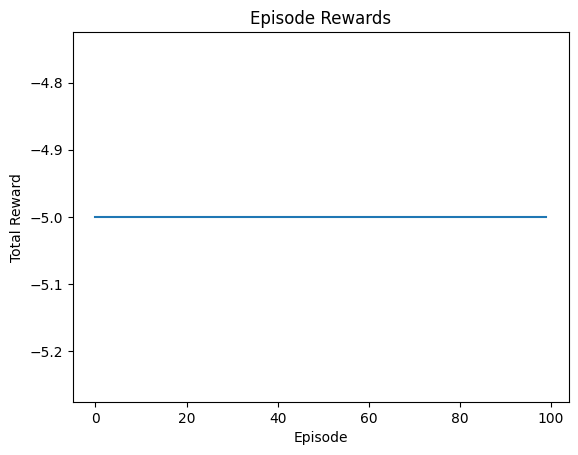

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.envs.registration import register
import matplotlib.pyplot as plt

register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=1,  # Adjust the reward threshold if needed
)

class CustomRewardFrozenLake(gym.Env):
    def __init__(self):
        self.env = gym.make("CustomRewardFrozenLake-v1")
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if reward == 0 and not done:
            reward = 0
        elif reward == 0 and done:
            reward = -5
        elif reward == 1:
            reward = 1
        return state, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

# Define Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Define Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Discounted rewards function
def discount_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

# Function to compute advantages
def compute_advantages(critic, states, rewards):
    values = critic(states)
    advantages = rewards - values.squeeze()  # Squeeze to remove extra dimensions
    return advantages

# Initialize the environment
env = CustomRewardFrozenLake()
input_dim = env.observation_space.n
output_dim = env.action_space.n

# Initialize the actor and critic networks
actor = Actor(input_dim, output_dim)
critic = Critic(input_dim)

# Initialize the optimizers
optimizer_actor = optim.Adam(actor.parameters(), lr=0.01)
optimizer_critic = optim.Adam(critic.parameters(), lr=0.01)

# Initialize variables for tracking performance
episode_rewards = []
successes = []

# Training loop
for episode in range(100):
    state = env.reset()
    episode_reward = 0
    success = False

    states = []
    actions = []
    rewards = []

    while True:
        # Convert the state to a one-hot encoded tensor
        state_one_hot = torch.zeros(1, input_dim)
        state_one_hot[0, state] = 1
        states.append(state_one_hot)

        action_probs = actor(state_one_hot)  # Pass the one-hot encoded state to the actor
        action = torch.multinomial(action_probs, num_samples=1).item()
        actions.append(action)

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        episode_reward += reward
        state = next_state

        if done:
            discounted_rewards = torch.tensor(discount_rewards(rewards), dtype=torch.float32)
            advantages = compute_advantages(critic, torch.stack(states), discounted_rewards)

            # Compute actor loss
            stacked_states = torch.stack(states)
            log_probs = torch.log(actor(stacked_states))
            log_probs_flat = log_probs.view(-1, output_dim)

            # Correct the indexing to account for batch size and actions
            batch_size = log_probs_flat.shape[0]
            idx = torch.arange(batch_size) * output_dim + torch.tensor(actions)
            log_probs_selected = log_probs_flat.view(-1)[idx]
            if len(actions) != log_probs_selected.shape[0]:
                print("Error: Actions size and log_probs shape do not match.")
            actor_loss = -(log_probs_selected * advantages).mean()

            # Compute critic loss
            critic_loss = ((critic(stacked_states).squeeze() - discounted_rewards)**2).mean()

            # Update actor and critic
            optimizer_actor.zero_grad()
            optimizer_critic.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            optimizer_actor.step()
            optimizer_critic.step()

            episode_rewards.append(episode_reward)
            successes.append(reward == 1)  # Check if the episode was successful

            print("Episode: {}, Reward: {}".format(episode, episode_reward))
            print("Success Rate: {:.2f}%".format(sum(successes) / len(successes) * 100))
            break

# Plot performance
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

env.close()
